In [6]:
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import numpy as np
import pandas as pd
import time
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap
import random

In [7]:
class Robot(Agent):
    def __init__(self, id, model, pos, trash_bin, target_position,zone):
        super().__init__(id, model)
        self.id = id
        self.pos = pos
        self.trash_capacity = 5
        self.current_trash = 0
        self.trash_bin = trash_bin
        self.original_cell_value = self.model.grid_data[pos[1]][pos[0]]
        self.mapping = True
        self.go_zone = True
        self.zone = zone
        self.target_position = target_position
        self.previous_pos = None
        self.previous_pos_two = None
        self.i = 0

    def is_valid_position(self, pos):
        return 0 <= pos[0] < len(self.model.grid_data[0]) and 0 <= pos[1] < len(self.model.grid_data)

    def get_possible_steps(self, current_pos):
        possible_steps = self.model.grid.get_neighborhood(
            current_pos,
            moore=True,
            include_center=False,
        )
        
        return possible_steps
    
    def get_filtered_possible_steps(self, current_pos, radius=1):
        disallowed_values = {101, 105, 106, 107, 108, 109}

        possible_steps = self.model.grid.get_neighborhood(
            current_pos,
            moore=True,
            include_center=False,
            radius=radius
        )
        if len(possible_steps) <= 2:
            return [pos for pos in possible_steps if self.is_valid_position(pos) and self.model.grid_data[pos[1]][pos[0]] not in disallowed_values]
        else:
            return [pos for pos in possible_steps if self.is_valid_position(pos) and self.model.grid_data[pos[1]][pos[0]] not in disallowed_values and pos != self.previous_pos and pos != self.previous_pos_two]

    def move_to_position(self, next_position):
        self.previous_pos_two = self.previous_pos 
        self.previous_pos = self.pos
        self.model.grid_data[self.pos[1]][self.pos[0]] = self.original_cell_value
        self.original_cell_value = self.model.grid_data[next_position[1]][next_position[0]]
        self.model.grid.move_agent(self, next_position)
        self.model.grid_data[next_position[1]][next_position[0]] = self.unique_id

    def step(self):
        if self.mapping:
            disallowed_values = {101, 105, 106, 107, 108, 109}

            if self.go_zone:
                # Si aún no hemos llegado a la posición objetivo o estamos lo suficientemente cerca
                distance_to_target = abs(self.pos[0] - self.target_position[0]) + abs(self.pos[1] - self.target_position[1])
                
                if distance_to_target > 2:  # Asumo que quieres que esté dentro de un radio de 2 para considerarlo "cerca".
                    # Moverse hacia la posición objetivo
                    self.map_colmena(self.get_possible_steps(self.pos))
                    possible_steps = self.get_filtered_possible_steps(self.pos)
                    
                    if not possible_steps:
                        return
                    
                    next_position = min(possible_steps, key=lambda pos: abs(pos[0] - self.target_position[0]) + abs(pos[1] - self.target_position[1]))
                    
                    # Realizar movimiento
                    if self.is_valid_position(next_position):
                        self.move_to_position(next_position)
                else:
                        self.go_zone = False

            else:
                zero_positions = [(x, y) for y in range(self.zone[2], self.zone[3]) for x in range(self.zone[0], self.zone[1]) if model.colmena[y][x] == 0]
                if not zero_positions:
                    self.mapping = False
                    return
        
                zero_positions.sort(key=lambda pos: abs(pos[0] - self.pos[0]) + abs(pos[1] - self.pos[1]))
        
                target_position = zero_positions[0]
                possible_steps = self.get_filtered_possible_steps(self.pos)
                if possible_steps:
                    next_position = min(possible_steps, key=lambda pos: abs(pos[0] - target_position[0]) + abs(pos[1] - target_position[1]))
                else:
                    return
        
                if self.is_valid_position(next_position):
                    self.move_to_position(next_position)
                                
                self.map_colmena(self.get_possible_steps(self.pos))
                                
                            
        else:
            # Recoger basura o mover al basurero dependiendo de la capacidad actual
            possible_steps = self.get_filtered_possible_steps(self.pos)

            if not possible_steps:
                return

            if self.current_trash == self.trash_capacity:
                if self.trash_bin != self.pos:
                    next_position = min(possible_steps, key=lambda pos: abs(pos[0] - self.trash_bin[0]) + abs(pos[1] - self.trash_bin[1]))
                else:
                    self.current_trash = 0
                    next_position = random.choice(possible_steps)
            else:
                trash_positions = [(x, y) for y in range(len(model.colmena)) for x in range(len(model.colmena[0])) if model.colmena[y][x] == 1]

                if not trash_positions:
                    if self.trash_bin != self.pos:
                        next_position = min(possible_steps, key=lambda pos: abs(pos[0] - self.trash_bin[0]) + abs(pos[1] - self.trash_bin[1]))
                    else:
                        self.current_trash = 0
                        self.model.grid_data[self.pos[1]][self.pos[0]] = 103

                        self.model.grid.remove_agent(self)
                        self.model.schedule.remove(self)
                        
                        return 
                else:
                    # Ordenar las posiciones de basura según la distancia al robot.
                    trash_positions.sort(key=lambda pos: abs(pos[0] - self.pos[0]) + abs(pos[1] - self.pos[1]))
                    
                    target_position = trash_positions[0]
                    possible_steps = self.get_filtered_possible_steps(self.pos)
                    next_position = min(possible_steps, key=lambda pos: abs(pos[0] - target_position[0]) + abs(pos[1] - target_position[1]))
                    
                    if self.is_valid_position(next_position):
                        self.move_to_position(next_position)
                    
                        if self.original_cell_value > 0 and self.original_cell_value < 10:
                            trash = min(5 - self.current_trash, self.original_cell_value)
                            self.current_trash += trash
                            self.original_cell_value -= trash
                            
                            if self.original_cell_value == 0:
                                    self.model.colmena[self.pos[1]][self.pos[0]] = 50

            if self.is_valid_position(next_position):
                self.move_to_position(next_position)

    def map_colmena(self, possible_steps):
        for pos in possible_steps:
            cell_value = self.model.grid_data[pos[1]][pos[0]]
            
            # Chequeamos las condiciones dadas y modificamos colmena_matrix acorde
            if cell_value == 101:
                self.model.colmena[pos[1]][pos[0]] = 101
            elif cell_value == 0:
                self.model.colmena[pos[1]][pos[0]] = 50
            elif 1 <= cell_value <= 10:
                self.model.colmena[pos[1]][pos[0]] = 1
            elif cell_value == 102 or cell_value == 103:
                self.model.colmena[pos[1]][pos[0]] = 50



In [8]:
def read_input(filename):
    with open(filename, 'r') as file:
        n, m = map(int, file.readline().split())
        office_layout = [file.readline().split() for _ in range(n)]
        return n, m, office_layout

def get_grid(model):
    return model.grid_data.copy()


In [9]:
class Oficina(Model):
    def __init__(self, filename):
        self.filename = filename
        n, m, office_layout = read_input(filename)  
        self.grid = MultiGrid(m, n, torus = False)
        self.colmena = np.zeros((n, m))
        
        # Inicializa grid_data con valores basados en office_layout
        self.grid_data = np.zeros((n, m))

        self.trash_bin = None
        
        for i in range(n):
            for j in range(m):
                cell_value = office_layout[i][j]
                if cell_value == 'X':
                    self.grid_data[i][j] = 101
                elif cell_value == 'S':
                    self.grid_data[i][j] = 102
                elif cell_value == 'P':
                    self.grid_data[i][j] = 103
                    self.trash_bin = (j, i)
                else:
                    self.grid_data[i][j] = int(cell_value)
                
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
        for y in range(n):
            for x in range(m):
                if office_layout[y][x] == 'S':
                    for z in range(5):
                        if z == 0:
                            target_position = (0,0)
                            zone=[0,int(m/2),0,int(n/2)]
                        elif z == 1:
                            target_position = (0,n)
                            zone=[int(m/2),int(m),int(0),int(n/2)]
                        elif z == 2:
                            target_position = (m,n)
                            zone=[0,int(m/2),int(n/2),n]
                        elif z == 3:
                            target_position = (m,0)
                            zone=[int(m/2),m,int(n/2),n]
                        elif z == 4:
                            target_position = (m/2,n/2)
                            zone=[int(m/4),int((3*m)/4),int(n/4),int((3*n)/4)]
                        
                        robot = Robot(z+105, self, (x, y), self.trash_bin, target_position,zone)
                        self.grid.place_agent(robot, (x, y))
                        self.schedule.add(robot)
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        

In [10]:
MAX_ITERATIONS = 5000
flag = True
model = Oficina("input5.txt")
for i in range(MAX_ITERATIONS):
    model.step()
    if len(model.schedule.agents) == 0 and flag == True :
        print(i)
        flag = False


count=0
count3=0

for y in range(len(model.colmena)):
        for x in range(len(model.colmena[0])):
            if model.colmena[y][x] == 1 :
                count+=1
            if model.colmena[y][x] == 0 :
                count3+=1

print(count)
print(count3)



2881
0
0


In [11]:
all_grid = model.datacollector.get_model_vars_dataframe()

In [12]:
def save_transformed_grid_to_txt(numeric_grid,n,m):
    filename='grid_data.txt'
    # Hacer las transformaciones
    transformed_grid = []
    for row in numeric_grid:
        transformed_row = []
        for value in row:
            if value == 101:
                transformed_row.append("X")
            elif value == 102 or 105 <= value <= 109:
                transformed_row.append("S")
            elif value == 103:
                transformed_row.append("P")
            else:
                transformed_row.append(str(int(value)))
        transformed_grid.append(" ".join(transformed_row))

    count = 1
    # Guardar en archivo txt
    with open(filename, 'a') as file:
        if count == 1:
            file.write(str(n) + ' ' + str(m) + '\n')
        for row in transformed_grid:
            file.write(row + '\n')
        file.write('\n')  # Para separar grids con una línea en blanco

In [13]:
for i in range(MAX_ITERATIONS):
    if i < len(all_grid):
        numeric_grid = all_grid.iloc[i][0]

        # Llamar a la función para guardar el grid transformado
        save_transformed_grid_to_txt(numeric_grid,len(model.colmena),len(model.colmena[0]))

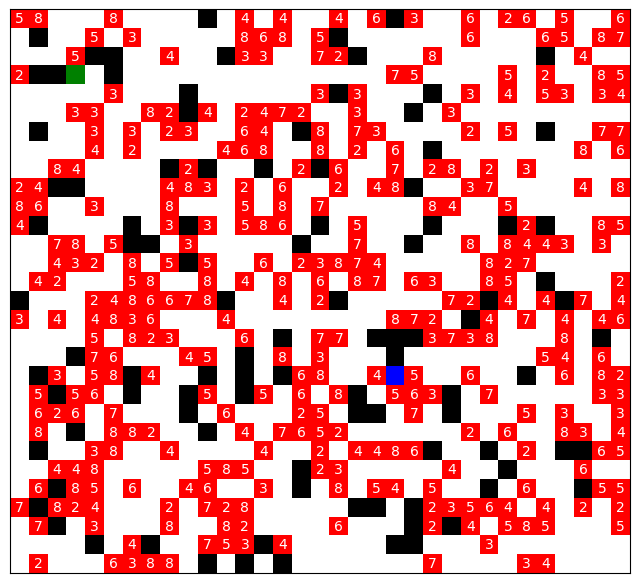

In [14]:
colors = ['white','red', 'black', 'blue', 'green', 'purple']
bounds = [0, 0.5, 100.5, 101.5, 102.5, 103.5, 200]  # Asumiendo que el ID del robot es < 200
norm = BoundaryNorm(bounds, len(colors))

cmap = ListedColormap(colors)

fig, axs = plt.subplots(figsize=(8,8))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, norm=norm)

def animate(i):
    if i < len(all_grid):
        numeric_grid = all_grid.iloc[i][0]

        # Limpia cualquier texto anterior
        for txt in axs.texts:
            txt.remove()
        
        # Recorre la matriz y verifica cada valor
        for row_idx, row in enumerate(numeric_grid):
            for col_idx, value in enumerate(row):
                if value not in [0, 101, 102, 103]:
                    # Muestra el valor en la celda roja como un entero
                    axs.text(col_idx, row_idx, str(int(value)), ha='center', va='center', color='white')
        
        patch.set_data(numeric_grid)
    
    else:
        pass
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITERATIONS)

In [ ]:

anim